In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 15
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [4]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*distance)) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()

  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  print('indiv loss ', (loss_sum/tot_len))
  print('subgroup loss: ', subgroup_loss)
  tot_loss = (loss_sum/tot_len)*(max_val-min_val)
  tot_loss += subgroup_loss
  print('indiv loss ', tot_loss)
  print('subgroup loss: ', subgroup_loss)
  return tot_loss


In [6]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  for i in range(len(centroids)):
    # del df['loss_from_{}'.format(i)]
    lst = df['min_centr'].unique()
    if i not in lst:
      del df['dist_from_{}'.format(i)]
  return df

In [7]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [8]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (x - centr[0])) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (y - centr[1])) / (1 + np.exp(-1*distance)*distance)
  new_centr_x -= (grad_x) * lr
  new_centr_y -= (grad_y) * lr
  return (new_centr_x, new_centr_y)

In [9]:
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1):
  samp = groups[cdf1].sample(n=b, random_state=1)
  # samp = df.sample(n=b, random_state=1)
  samp = samp.reset_index()
  start = time.time()
  # print(samp['min_centr'])
  for i in centroids.keys():
    count[i] = 0
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    temp_centroids[clust] = temp
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [10]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids, df, subgroup_loss, loss, groups, cdf1):
  tot_loss_lst = []
  b = 1000
  max_iter = 50
  iter_num = 0
  conv = 3
  j = 0
  tot_loss_lst.append(loss)
  L = perc * subgroup_loss
  print('L: ', L)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  # while subgroup_loss > L and iter_num < max_iter:
  while iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    print('iteration number: ', iter_num)
    print('old loss: ', old_loss)
    print('temp loss: ', temp_loss)
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in centroids.keys():
          if temp_centroids[i] != 0:
            centroids[i] = temp_centroids[i]

        fig = plt.figure(figsize=(5,5))
        ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

        for i in centroids.keys():
          plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])

        plt.xlim(0, 20)
        plt.ylim(0, 20)
        ax.set_title("Synthetic Data")
        plt.show()
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  return centroids    

In [11]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  return (max_ind, min_ind)

In [12]:
def compute_cdf_graph(groups):
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [13]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [14]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  2.7078857421875


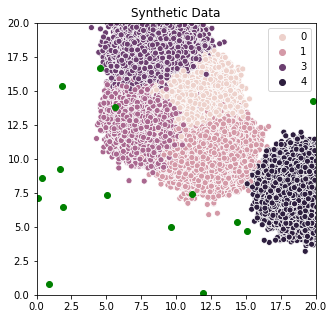

{0: (0.4231572272985895, 8.60309380430836),
 1: (0.12386820116704556, 7.148442418879437),
 2: (5.015011371261253, 7.347034122555092),
 3: (15.072630703584531, 4.660684305133584),
 4: (1.8141537663433693, 15.337873452845399),
 5: (19.84910346528355, 14.262179209389682),
 6: (0.8898723935151076, 0.7963050896127188),
 7: (1.9121227466802537, 6.4832987411180625),
 8: (4.58055195358702, 16.690403092228337),
 9: (1.649549745607326, 9.238058130910156),
 10: (11.160262477578161, 7.432969209951179),
 11: (14.38395396521943, 5.349087056314246),
 12: (11.924021886483507, 0.11593392230672572),
 13: (9.648090366586136, 5.011001798859036),
 14: (5.596385461754274, 13.853794526755747)}

In [15]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification


# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=800000, n_classes=6,shift=4 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.5,.1,.1, .5, .15, .1], random_state=55)
center_box = (0,20)
X, y = make_blobs(n_samples=800000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})
df['group'] = y


#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.uniform(0,20)), (random.uniform(0,20)))
#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(0, 20)
plt.ylim(0, 20)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  2.8226983547210693


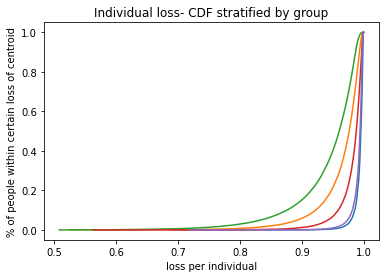

indiv loss  0.9744563577965032
subgroup loss:  0.03514644433257852
indiv loss  0.5138747194337427
subgroup loss:  0.03514644433257852
L:  0.02460251103280496
Time elapsed Batch Step:  0.431781530380249
Time elapsed Assignment Step:  2.6967432498931885
indiv loss  0.9773559083969583
subgroup loss:  0.029477279865396055
indiv loss  0.510713867777089
subgroup loss:  0.029477279865396055
iteration number:  1
old loss:  0.5138747194337427
temp loss:  0.510713867777089


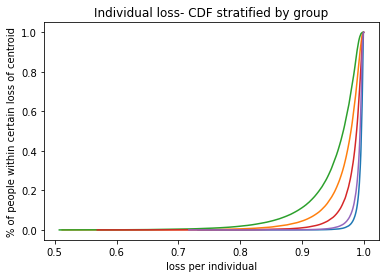

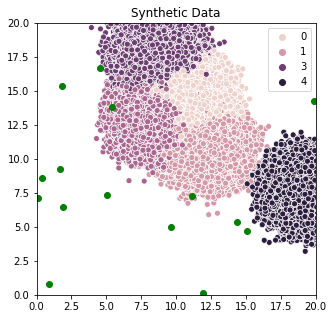

Time elapsed Batch Step:  0.4653754234313965
Time elapsed Assignment Step:  2.7441160678863525
indiv loss  0.9795850481689249
subgroup loss:  0.025277583849996788
indiv loss  0.4979013280589335
subgroup loss:  0.025277583849996788
iteration number:  2
old loss:  0.510713867777089
temp loss:  0.4979013280589335


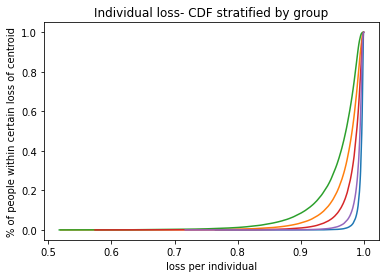

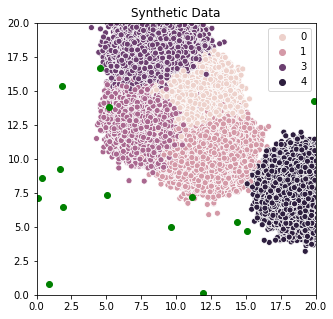

Time elapsed Batch Step:  0.4503636360168457
Time elapsed Assignment Step:  2.6782619953155518
indiv loss  0.9814759407281602
subgroup loss:  0.022038783637241433
indiv loss  0.5026267846542616
subgroup loss:  0.022038783637241433
iteration number:  3
old loss:  0.4979013280589335
temp loss:  0.5026267846542616
Time elapsed Batch Step:  0.44805288314819336
Time elapsed Assignment Step:  2.6707165241241455
indiv loss  0.9830329913016485
subgroup loss:  0.01946975767060377
indiv loss  0.4778679081979928
subgroup loss:  0.01946975767060377
iteration number:  4
old loss:  0.4979013280589335
temp loss:  0.4778679081979928


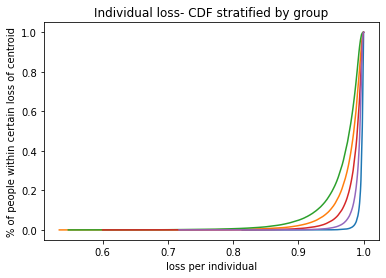

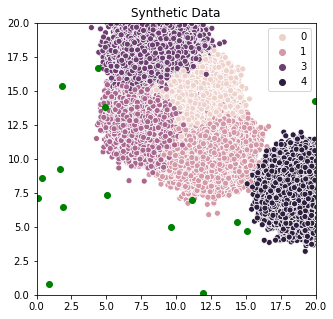

Time elapsed Batch Step:  0.4348008632659912
Time elapsed Assignment Step:  2.6376209259033203
indiv loss  0.9843454327506339
subgroup loss:  0.01738404812658756
indiv loss  0.49154128887677295
subgroup loss:  0.01738404812658756
iteration number:  5
old loss:  0.4778679081979928
temp loss:  0.49154128887677295
Time elapsed Batch Step:  0.4367663860321045
Time elapsed Assignment Step:  2.673917293548584
indiv loss  0.9854676870086078
subgroup loss:  0.01569216490247516
indiv loss  0.48956053867918553
subgroup loss:  0.01569216490247516
iteration number:  6
old loss:  0.4778679081979928
temp loss:  0.48956053867918553
Time elapsed Batch Step:  0.42926025390625
Time elapsed Assignment Step:  2.665189743041992
indiv loss  0.9864228164590306
subgroup loss:  0.01427796066932474
indiv loss  0.4998483944184837
subgroup loss:  0.01427796066932474
iteration number:  7
old loss:  0.4778679081979928
temp loss:  0.4998483944184837
Time elapsed End of Update Step:  4.569782733917236


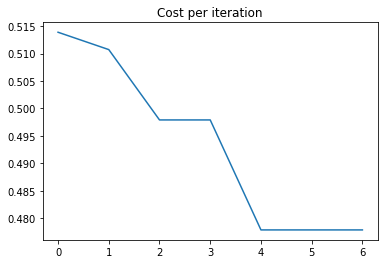

{0: (0.4231572272985895, 8.60309380430836),
 1: (0.12386820116704556, 7.148442418879437),
 2: (5.015011371261253, 7.347034122555092),
 3: (15.072630703584531, 4.660684305133584),
 4: (1.8141537663433693, 15.337873452845399),
 5: (19.988291807372832, 14.255728218373699),
 6: (0.8898723935151076, 0.7963050896127188),
 7: (1.9121227466802537, 6.4832987411180625),
 8: (4.390168196708202, 16.687544098855494),
 9: (1.649549745607326, 9.238058130910156),
 10: (11.128232239792307, 6.966131604120396),
 11: (14.38395396521943, 5.349087056314246),
 12: (11.924021886483507, 0.11593392230672572),
 13: (9.648090366586136, 5.011001798859036),
 14: (4.9023325838102245, 13.788102484852363)}

In [16]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(.7, centroids,df, subgroup_loss, loss, groups, cdf1)

In [17]:
centroids 

{0: (0.4231572272985895, 8.60309380430836),
 1: (0.12386820116704556, 7.148442418879437),
 2: (5.015011371261253, 7.347034122555092),
 3: (15.072630703584531, 4.660684305133584),
 4: (1.8141537663433693, 15.337873452845399),
 5: (19.988291807372832, 14.255728218373699),
 6: (0.8898723935151076, 0.7963050896127188),
 7: (1.9121227466802537, 6.4832987411180625),
 8: (4.390168196708202, 16.687544098855494),
 9: (1.649549745607326, 9.238058130910156),
 10: (11.128232239792307, 6.966131604120396),
 11: (14.38395396521943, 5.349087056314246),
 12: (11.924021886483507, 0.11593392230672572),
 13: (9.648090366586136, 5.011001798859036),
 14: (4.9023325838102245, 13.788102484852363)}